In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download sumitsahay/preprocessedv2faceshapedataset

 88% 65.0M/73.9M [00:00<00:00, 133MB/s]
100% 73.9M/73.9M [00:00<00:00, 119MB/s]


In [6]:
! unzip /content/preprocessedv2faceshapedataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: faceshape_bw/training_set/Square/square (992).jpg  
  inflating: faceshape_bw/training_set/Square/square (993).jpg  
  inflating: faceshape_bw/training_set/Square/square (994).jpg  
  inflating: faceshape_bw/training_set/Square/square (995).jpg  
  inflating: faceshape_bw/training_set/Square/square (996).jpg  
  inflating: faceshape_bw/training_set/Square/square (997).jpg  
  inflating: faceshape_bw/training_set/Square/square (998).jpg  
  inflating: faceshape_bw/training_set/Square/square (999).jpg  
  inflating: training_set/testing_set/Heart/heart (101).jpg  
  inflating: training_set/testing_set/Heart/heart (102).jpg  
  inflating: training_set/testing_set/Heart/heart (123).jpg  
  inflating: training_set/testing_set/Heart/heart (13).jpg  
  inflating: training_set/testing_set/Heart/heart (135).jpg  
  inflating: training_set/testing_set/Heart/heart (136).jpg  
  inflating: training_set/testing_set/Heart/heart (137).jp

In [1]:
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics
import os

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory


import math
import matplotlib.pyplot as plt
from imutils import face_utils
import dlib
import cv2
import argparse
import math
from PIL import Image
from tqdm import tqdm

import pydot
import pydotplus
import keras

print("Done importing packages!")

Done importing packages!


### Code for Handling Corrupted Images

In [5]:
import glob
import pathlib
from struct import unpack

# # search all files inside a specific folder
# # *.* means file name with any extension
dir_path = 'datasets/FaceShapeDataset/**/*.jpg'
imgList = [file for file in glob.glob(dir_path, recursive=True)]
len(imgList)

5000

In [6]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

# Initializing a list to contain corrupted image paths
bads = []

# For every image in dataset try decoding, if fails it's a corrupted image
for img in tqdm(imgList):
    image = img
    image = JPEG(image)
    try:
        image.decode()   
    except:
        bads.append(img)

print(f"Total Number of Corrupted Images: {len(bads)}")
print(f"Corrupted Images List:- \n{bads}")

# Removing Corrupted Images
for name in bads:
    os.remove(name)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 175.91it/s]

Total Number of Corrupted Images: 7
Corrupted Images List:- 
['datasets/FaceShapeDataset\\testing_set\\Square\\square (154).jpg', 'datasets/FaceShapeDataset\\training_set\\Heart\\heart (633).jpg', 'datasets/FaceShapeDataset\\training_set\\Oblong\\oblong (745).jpg', 'datasets/FaceShapeDataset\\training_set\\Oblong\\oblong (751).jpg', 'datasets/FaceShapeDataset\\training_set\\Oblong\\oblong (776).jpg', 'datasets/FaceShapeDataset\\training_set\\Square\\square (172).jpg', 'datasets/FaceShapeDataset\\training_set\\Square\\square (84).jpg']


# Pre-Processing Pipeline

## 1. Face Alignment

In [4]:
def get_angle(point_1, point_2):
    '''
    Takes two point coordinates and join them to create a line in order to 
    find out the angle w.r.t X-axis
    
    Input:
    point_1 : Point A
    point_2 : Point B
    
    Returns:
    angle: Angle w.r.t X-axis in degrees
    '''
    
    angle = math.atan2(point_1[1] - point_2[1], point_1[0] - point_2[0])
    
    angle = math.degrees(angle)

    if angle < -90:
        return (180-abs(angle))
    elif angle >=90 or angle == -90:
        return 0
    return angle


def align_face(image, cascadeClassifier):
    '''
    Uses cascade classifier to align the face to be straight 
    instead of being tilted at some angle
    
    Inputs:
    image : Target Image
    cascadeClassifer: Eye Cascade Classifer Model
    
    Returns:
    aligned_image: image with aligned face
    '''
    eyesLoc = cascadeClassifier.detectMultiScale(image.copy(), 
                                                 scaleFactor = 1.2, 
                                                 minNeighbors = 6)
    
    try:
        point_1 = (eyesLoc[0][0], eyesLoc[0][1])
        point_2 = (eyesLoc[1][0], eyesLoc[1][1])
                   
    
        rotationAngle = get_angle(point_1, point_2)
    
        alignedImage = np.asarray(Image.fromarray(image).rotate(rotationAngle))
        
        alignedShape = alignedImage.shape
    except:
        return image
        
    
    return alignedImage

## 2. Face Detection & Cropping

In [5]:
def draw_fancy_box(img, pt1, pt2, color, thickness, r, d):
    '''
    To draw some fancy box around founded faces in stream
    '''
    x1, y1 = pt1
    x2, y2 = pt2

    # Top left
    cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)

    # Top right
    cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)

    # Bottom left
    cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)

    # Bottom right
    cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)
    

def face_detection(image, detector):
    '''
    This face detector is made using the now classic Histogram of Oriented
    Gradients (HOG) feature combined with a linear classifier, an image
    pyramid, and sliding window detection scheme.  This type of object detector
    is fairly general and capable of detecting many types of semi-rigid objects
    in addition to human faces.
    
    This function detects the face using Dlib
    
    Input:
    image: Input Image containing human face
    detector: Dlib Face Detector Model
    
    Returns:
    image: image with bounded box representing the detected face
    
    face_coordinates : Coordinates of the detected face
    '''

    # Converting the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # The 1 in the second argument indicates that we should upsample the image
    # 1 time.  This will make everything bigger and allow us to detect more
    # faces.

    # Get faces from image
    rects = detector(gray, 1)
    
    face_cordinates = []
    # For each detected face, draw boxes.
    for (i, rect) in enumerate(rects):
        # Finding points for rectangle to draw on face
        x1, y1, x2, y2, w, h = rect.left(), rect.top(), rect.right() + \
            1, rect.bottom() + 1, rect.width(), rect.height()
    
        face_cordinates.append((math.floor(x1*0.8), math.floor(y1*0.60), math.ceil(h*1.40), math.ceil(h*1.40)))

        draw_fancy_box(image, (x1, y1), (x2, y2), (0, 0, 255), 2, 10, 20)

    return image, face_cordinates



def faceDetectAndCrop(image, detector):
    '''
    This function will use Face Detection to face and crop the image contain only face
    
    Input:
    image: Target image to be cropped
    detector: Dlib Face Detector Model
    
    Returns:
    cropped_face: a cropped image containing mostly the face
    '''
    face_coordinates = face_detection(image.copy(), detector)[1]
    
    # If face not detected return image as it is
    if len(face_coordinates) == 0:
        return image
    cropped_face = None
    
    maxArea = 0
    largestFaceIndex = 0
    # Choose the face which is largest
    for i, coordinates in enumerate(face_coordinates):
        (x1, y1, w, h) = coordinates
        
        # Calculating area
        area = w * h
        if area > maxArea:
            maxArea = area
            largestFaceIndex = i
        
    (x1, y1, w, h) = face_coordinates[largestFaceIndex]
    cropped_face = image.copy()[y1:y1 + h, x1:x1 + w]
    
    try:
        cropped_shape = cropped_face.shape
    except:
        return image
    
    if cropped_shape[1]==0:
        return image
    
    return cropped_face

In [6]:
def preprocessImage(image):
    '''
    This function preprocesses the image for Face Shape Detection Models
    It contains following steps of Pre-Processing:
    1. Face Alignment
    2. Face Detection and Cropping
    3. Grayscaling
    4. Image Resizing to 128x128
    
    Inputs:
    image: Image to be preprocessed
    
    Returns:
    resized: Preprocessed image
    '''
    # Aligning Face 
    alignedFace = align_face(image, eye_cascade)
    
    # Detecting and Cropping Face Area
    croppedFace = faceDetectAndCrop(alignedFace,face_detector)
    
    # Converting Image to GrayScale
    grayscaled = cv2.cvtColor(croppedFace, cv2.COLOR_BGR2GRAY)
    
    # Resizing Image
    resized = cv2.resize(grayscaled, (128, 128))
               
    return resized

In [7]:
# Loading Models for Pre-Processing
eye_cascade = cv2.CascadeClassifier('face_alignment\haarcascade_eye.xml')
face_detector = dlib.get_frontal_face_detector()

### Code for Pre-Processing all the Images in the dataset

In [ ]:
# Specifying Source Dataset Directory
rootdir = "datasets\FaceShapeDataset\\"

# Destination where preprocessed dataset will be wrote
preprocessedRoot = "preprocessed"

# Create destination directory if not exists
if not os.path.exists(preprocessedRoot):
    os.mkdir(preprocessedRoot)

# Walk through all the directory, subdirectories and files for Source directory
for subdir, dirs, files in tqdm(os.walk(rootdir)):
    
    # Resolve current sub-directory name
    subDirectoryName = "\\".join(subdir.split("\\")[1:])
    
    # Specifying output folder based on subdirectory name
    outputFolder = os.path.join(preprocessedRoot, subDirectoryName)
    
    # Creating output subdirectory
    if subDirectoryName!='' and not os.path.exists(outputFolder):
        os.mkdir(outputFolder)
        
    # For every image files
    for file in files:
        # Ignoring Desktop.ini if exists
        if file=='desktop.ini':
            continue
        
        # Defining Input/Output path
        inputPath = os.path.join(subdir, file)
        outputPath = os.path.join(outputFolder, file)
        
        if os.path.exists(outputPath):
            continue
        
        # Reading the image
        image = cv2.imread(inputPath)
        
        try:
            img_shape = image.shape
        except:
            continue
        
        # Preprocessing the image
        preprocessedImage = preprocessImage(image)

        try:
            # Writing to destination
            cv2.imwrite(outputPath, preprocessedImage)
        except:
            # If failed, printing path
            print(inputPath)


# Model Building & Training

In [8]:
BATCH_SIZE = 156
IMG_SIZE = (128, 128)

# Defining Dataset Directory Path
data_dir = "datasets/preprocessed/FaceShapeDataset/"

train_dataset = image_dataset_from_directory(data_dir+"training_set",
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir+"testing_set",
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             image_size=IMG_SIZE)

Found 3993 files belonging to 5 classes.
Found 999 files belonging to 5 classes.


In [9]:
class_names = train_dataset.class_names
num_classes = len(class_names)

for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Heart
2.  Oblong
3.  Oval
4.  Round
5.  Square


In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 1


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
# add more augmentations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])

In [8]:
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Large(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE
                            )

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-08-20 10:15:23.124906: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2022-08-20 10:15:23.797309: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-20 10:15:23.798234: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-20 10:15:23.798285: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-20 10:15:23.798899: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-20 10:15:23.799018: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(156, 1, 1, 1280)


In [19]:
base_model.trainable = True

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(156, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(156, 5)


In [22]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
# Initializing model output directory name
modelNameDirectory = 'FaceDetectionModel'

# Creating model directory if doest not exists
if not os.path.exists(modelNameDirectory):
    os.mkdir(modelNameDirectory)

# Defining model file name
filePath = modelNameDirectory + '/' + 'MobileNetV3-L'+ '_BestModel.h5'

# Defining model checkpoint for saving best model
bestModelCheckpoint = ModelCheckpoint(filePath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Defining decaying learning rate callback
decayLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)

# Defining early stopping callback
earlystopCheckpoint = EarlyStopping(monitor="val_loss", min_delta=0, patience=9, verbose=1)

# Preparing list of all callbacks
callbacksList = [bestModelCheckpoint, decayLR, earlystopCheckpoint]

In [24]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS
              )

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0     

In [26]:
initial_epochs = 100

In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks = callbacksList
                    )

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.4441 - accuracy: 0.4160 - precision: 0.5440 - recall: 0.2537
Epoch 00001: val_loss improved from inf to 1.14295, saving model to FaceDetectionModel/MobileNetV3-L_BestModel.h5


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


26/26 [==============================] - 28s 513ms/step - loss: 1.4441 - accuracy: 0.4160 - precision: 0.5440 - recall: 0.2537 - val_loss: 1.1430 - val_accuracy: 0.5362 - val_precision: 0.6473 - val_recall: 0.4093 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.6834 - precision: 0.7746 - recall: 0.5930
Epoch 00002: val_loss improved from 1.14295 to 1.03398, saving model to FaceDetectionModel/MobileNetV3-L_BestModel.h5
26/26 [==============================] - 10s 394ms/step - loss: 0.8103 - accuracy: 0.6834 - precision: 0.7746 - recall: 0.5930 - val_loss: 1.0340 - val_accuracy: 0.6335 - val_precision: 0.7003 - val_recall: 0.5765 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8367 - precision: 0.8795 - recall: 0.7949
Epoch 00003: val_loss improved from 1.03398 to 1.02534, saving model to FaceDetectionModel/MobileNetV3-L_BestModel.h5
26/26 [==============================] - 8s 31

In [28]:
# Defining plot function for plotting Graph between Training and Validation loss as well as accuracy
def plot(x):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  axes[0].plot(x.history['loss'])   
  axes[0].plot(x.history['val_loss'])
  axes[0].legend(['Training Loss','Validation Loss'])

  axes[1].plot(x.history['accuracy'])   
  axes[1].plot(x.history['val_accuracy'])
  axes[1].legend(['Training Accuracy','Validation Accuracy'])

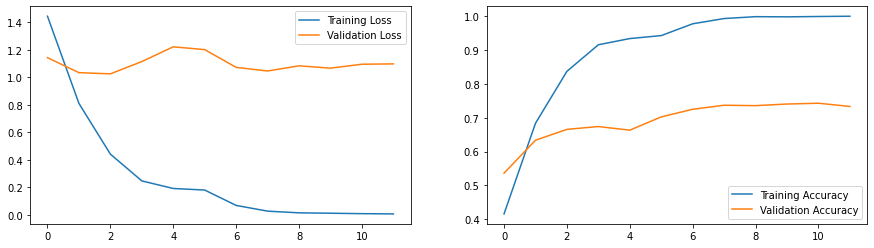

In [29]:
plot(history)

# Model Prediction on Test Dataset

In [11]:
# Loading FaceShapeDetecor MobileNetV3-Large Model
FSD_MobileNetV3_Large = tf.keras.models.load_model("FaceDetectionModel/MobileNetV3-L_BestModel.h5")

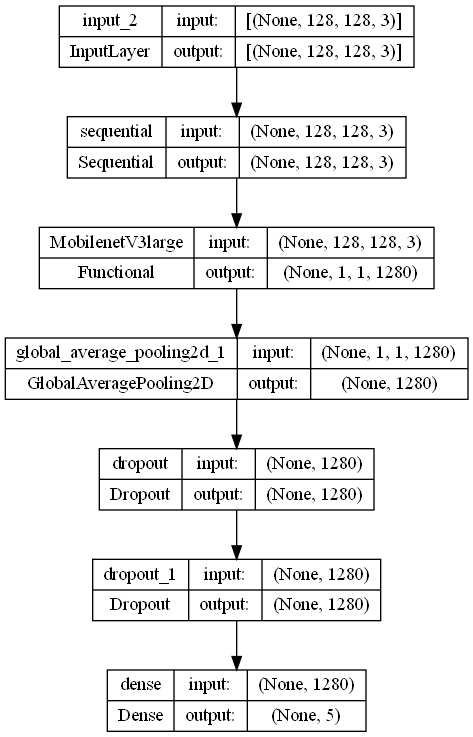

In [12]:
# Plotting Model Architecture
keras.utils.vis_utils.pydot = pydotplus
tf.keras.utils.plot_model(FSD_MobileNetV3_Large, to_file='MobileNetV3-L_BestModel.png', show_shapes=True)

In [18]:
%%time
# Evaluating FaceShapeDetecor MobileNetV3-Large Model
FSD_MobileNetV3_Large.evaluate(test_dataset)

1/1 [==============================] - 0s 474ms/step - loss: 1.1942 - accuracy: 0.6731 - precision: 0.7101 - recall: 0.6282
Wall time: 505 ms


[1.194201111793518, 0.6730769276618958, 0.7101449370384216, 0.6282051205635071]

# Prediction Pipeline

In [14]:
# Reading a Single Original Image
image = cv2.imread("datasets/FaceShapeDataset/testing_set/Oblong/oblong (926).jpg")

In [17]:
%%time

# Preprocessing Image
preprocessedImage = cv2.cvtColor(preprocessImage(image), cv2.COLOR_BGR2RGB)

# Reshaping Image to feed into model
reshapedImage = preprocessedImage.reshape((1,128,128,3))

# Predicting
FSD_MobileNetV3_Large.predict(reshapedImage)

1/1 [==============================] - 0s 23ms/step
Wall time: 396 ms


array([[0.4105246 , 0.03152868, 0.36770493, 0.10205564, 0.08818618]],
      dtype=float32)